- what are the nearest neighbors of the additional graph structure induced by the adversary?

- Computing something like an "average" subgraph for a class might be difficult because it is unclear how we deal with conflicting directions on edge weights and how we actually average over all the possible subgraphs examples from various classes could elicit
    - But this analysis would be fairly interesting. Should think more about how to do this

In [1]:
import os
import parse
import pickle
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from pt_activation.models.alexnet import AlexNet

PERCENTILE = 95

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/cifar/projected_gradient_descent/alexnet_cifar.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [36]:
def get_adv_dists(adversaries, up_to):
    device = torch.device('cpu')
    dists = np.zeros(up_to)
    i = 0
    ims = []
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='../../data/cifar', train=False,
                        download=True, transform = transforms.Compose(
                        [transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])),
                        batch_size=1, shuffle=False)
    adv_images = np.array([a['adversary'] for a in adversaries])
    with torch.no_grad():
        for data, target in test_loader:
            d = data.numpy()[0].reshape(3*32*32)
            ims.append(d)
            dists[i] = np.linalg.norm(d-adv_images[i].reshape(3*32*32),2)
            i += 1
            if i >= up_to:
                break
            
    return dists, ims

def create_sample_graph(f,tnms,wm):

    subgraphs = {}
    m = dion.homology_persistence(f)
    dgm = dion.init_diagrams(m,f)[0]
    for i,c in enumerate(m):
        if len(c) == 2:
            w = f[i].data
            if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
            elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
            if False: #tnms[f[c[0].index][0]] in subgraphs:
                subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
            else:
                eaten = False
                for k, v in subgraphs.items():
                    if v.has_node(tnms[f[c[0].index][0]]):
                        if tnms[f[c[1].index][0]] in subgraphs:
                            v.add_node(f[c[1].index][0])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                        else:
                            v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        eaten = True
                        break
                if not eaten:
                    g = nx.Graph()
                    g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                    subgraphs[tnms[f[c[0].index][0]]] = g

    return subgraphs, dgm, create_lifetimes(f,subgraphs,dgm,tnms)

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]]
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes



# In[9]:


def create_subgraphs(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='../../data/cifar', train=False,
                        download=True, transform = transforms.Compose(
                        [transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])),
                        batch_size=batch_size, shuffle=False)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_induced_filtration(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes


def create_adversary_subgraphs(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]

    print(adv_images.shape, adv_labels.shape)

    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_induced_filtration(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes

def create_moved_subgraphs(model, ims, labels, devs, batch_size, up_to, times=1):
    device = torch.device("cpu")

    nims = []
    for i in range(len(ims)):
#         print('finding alteration number', i)
        im = ims[i]
        dev = devs[i]
        delim = np.zeros(im.shape, dtype=im.dtype)
        sigma = 0
        while np.linalg.norm(im+delim - im) < dev:
            sigma += 0.00001
            delim = np.random.normal(scale=sigma, size=im.shape)
        nims.append((im+delim).reshape(3,32,32))
    tims = torch.FloatTensor(nims)
    tlabels = torch.tensor(np.array(labels))
    dataset = torch.utils.data.TensorDataset(tims, tlabels)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
#     with torch.no_grad():

#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output, hiddens = model(data, hiddens=True)
#             test_loss = F.nll_loss(output, target).item() # sum up batch loss
#             pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()
#             for s in range(data.shape[0]):
#                 this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
#                 print('Filtration: {}'.format(s+t))
#                 f, nm, wm = model.compute_induced_filtration(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
#                 tnm = {v: k for k, v in nm.items()}
#                 sg, dg, lifetime = create_sample_graph(f, tnm, wm)
#                 row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
#                 res_df.append(row)
#                 subgraphs.append(sg)
#                 diagrams.append(dg)
#                 lifetimes.append(lifetime)

#             t += (batch_size)
#             if t >= up_to:
#                 break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes, nims

    

    

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/alexnet_cifar.pt'
model = AlexNet()
model.load_state_dict(torch.load(model_location, map_location='cpu'))

In [6]:
res_df, sample_graphs, diagrams, lifetimes = create_subgraphs(model, 50, 50)

Files already downloaded and verified
Filtration: 0
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [1.14800382 1.14800382 0.21248299 0.63744897 0.05179652 0.04195053
 0.07266609 0.50866264 0.0211885  0.00245262 0.00823752]
creating filtration object...
filtration size 964937
Sorting filtration...
Filtration: 1
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [1.2545993  1.2545993  0.27385739 0.82157216 0.08019178 0.06561237
 0.13780279 0.96461955 0.04181296 0.00489045 0.01693928]
creating filtration object...
filtration size 938213
Sorting filtration...
Filtration: 2
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.93128154 0.93128154 0.14685917 0.44057752 0.04380217 0.03300174
 0.07351834 0.51462838 0.02149863 0.00253355 0.00861808]
creating filtration 

cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.91176702 0.91176702 0.17379251 0.52137754 0.04832241 0.03871556
 0.09589869 0.67129082 0.03130551 0.00371171 0.01481063]
creating filtration object...
filtration size 936095
Sorting filtration...
Filtration: 25
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [1.00447324 1.00447324 0.21879033 0.65637099 0.07119053 0.0434114
 0.0762792  0.53395439 0.02311472 0.00259894 0.00967984]
creating filtration object...
filtration size 932917
Sorting filtration...
Filtration: 26
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.79583466 0.79583466 0.15986663 0.47959989 0.04826798 0.03876584
 0.09384639 0.65692476 0.02870092 0.0031343  0.01009735]
creating filtration object...
filtration size 993055
Sorting filtration

layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.72422183 0.72422183 0.19570456 0.58711367 0.06562218 0.08190755
 0.21864678 1.53052745 0.06750171 0.00811669 0.02898068]
creating filtration object...
filtration size 909139
Sorting filtration...
Filtration: 49
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.51983707 0.51983707 0.16111678 0.48335033 0.04695782 0.03874434
 0.07549986 0.52849902 0.02393306 0.00279618 0.00989324]
creating filtration object...
filtration size 910408
Sorting filtration...


In [7]:
adv_df, adv_sample_graphs, adv_diagrams, adv_lifetimes = create_adversary_subgraphs(model, 50, 50, adversaries)

torch.Size([1000, 3, 32, 32]) torch.Size([1000])
Filtration: 0
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [1.14652041 1.14652041 0.21121516 0.63364548 0.0504319  0.03976583
 0.06931565 0.48520955 0.02034622 0.00237988 0.0080904 ]
creating filtration object...
filtration size 968904
Sorting filtration...
Filtration: 1
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [1.24620956 1.24620956 0.25233279 0.75699838 0.07714471 0.06426681
 0.13633553 0.95434873 0.04342009 0.00502333 0.01704348]
creating filtration object...
filtration size 936478
Sorting filtration...
Filtration: 2
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.93128154 0.93128154 0.14685917 0.44057752 0.04380217 0.03300174
 0.07351834 0.51462838 0.02149863 0.00253355 0.00861808]
creating 

Filtration: 24
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.91176702 0.91176702 0.17379251 0.52137754 0.04832241 0.03871556
 0.09589869 0.67129082 0.03130551 0.00371171 0.01481063]
creating filtration object...
filtration size 936095
Sorting filtration...
Filtration: 25
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.99650972 0.99650972 0.21703626 0.65110879 0.06933836 0.04284948
 0.07671022 0.53697155 0.02428576 0.00273523 0.0100697 ]
creating filtration object...
filtration size 930103
Sorting filtration...
Filtration: 26
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.79511109 0.79511109 0.15795451 0.47386354 0.04794405 0.03859563
 0.09319059 0.65233414 0.02889936 0.00315651 0.01012259]
creating filtration object...
filtration size 994701
So

layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.73115559 0.73115559 0.19337686 0.58013058 0.06416442 0.07586908
 0.19969005 1.39783032 0.06062912 0.00732635 0.02700086]
creating filtration object...
filtration size 910128
Sorting filtration...
Filtration: 49
cpu count: 4
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
layer: 5
layer: 6
layer: 7
layer: 8
layer: 9
layer: 10
percentiles: [0.5178827  0.5178827  0.1606203  0.48186091 0.04608605 0.03645939
 0.07051225 0.49358573 0.02250071 0.00264095 0.00966581]
creating filtration object...
filtration size 910334
Sorting filtration...


In [8]:
dists, ims = get_adv_dists(adversaries, 50)

Files already downloaded and verified


In [37]:
moved_df, moved_sample_graphs, moved_diagrams, moved_lifetimes, moved_ims = create_moved_subgraphs(model, ims, res_df['class'], dists, 50, 50, times=1)

KeyboardInterrupt: 

In [38]:
_, _, _, _, moved_ims = create_moved_subgraphs(model, ims, res_df['class'], dists, 50, 50, times=1)

In [10]:
print('Moved Accuracy:', moved_df[moved_df['prediction'] == moved_df['class']].shape[0]/moved_df.shape[0])
print('Actual Accuracy:', res_df[res_df['prediction'] == res_df['class']].shape[0]/res_df.shape[0])

Moved Accuracy: 0.82
Actual Accuracy: 0.82


In [11]:
res_df.head()

,class,loss,prediction
0,3,-8.79896,3
1,8,-8.79896,8
2,8,-8.79896,1
3,0,-8.79896,0
4,6,-8.79896,6


In [12]:
import pickle
with open(os.path.join(adv_directory_loc, 'moving_adv_samples.pkl'), 'wb') as f:
    pickle.dump(adv_sample_graphs, f)
with open(os.path.join(adv_directory_loc, 'moving_samples.pkl'), 'wb') as f:
    pickle.dump(sample_graphs, f)
with open(os.path.join(adv_directory_loc, 'moving_moved_samples.pkl'), 'wb') as f:
    pickle.dump(moved_sample_graphs, f)

In [13]:
res_df.head(10)

,class,loss,prediction
0,3,-8.79896,3
1,8,-8.79896,8
2,8,-8.79896,1
3,0,-8.79896,0
4,6,-8.79896,6
5,6,-8.79896,6
6,1,-8.79896,1
7,6,-8.79896,6
8,3,-8.79896,3
9,1,-8.79896,1


In [14]:
goi = 1

In [15]:
# plt.subplot(131).imshow(ims[goi].reshape(3,32,32).T, interpolation='nearest')
# plt.subplot(132).imshow(adv_ims[goi].reshape(3,32,32).T, interpolation='nearest')
# plt.subplot(133).imshow(moved_ims[goi].reshape(3,32,32).T, interpolation='nearest')

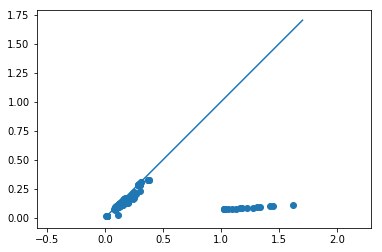

In [16]:
dion.plot.plot_diagram(diagrams[goi])

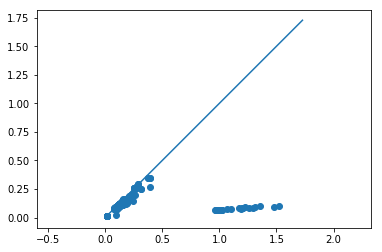

In [17]:
dion.plot.plot_diagram(adv_diagrams[goi])

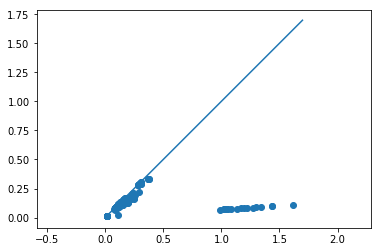

In [18]:
dion.plot.plot_diagram(moved_diagrams[goi])

In [19]:
lifetimes[goi]

{(8, 0, 100): 1.7015348672866821,
 (8, 0, 78): 1.5120328962802887,
 (8, 0, 136): 1.3436363115906715,
 (8, 0, 153): 1.3288786262273788,
 (8, 0, 25): 1.242962285876274,
 (8, 0, 145): 1.2233067899942398,
 (8, 0, 57): 1.1877081543207169,
 (8, 0, 150): 1.1380736529827118,
 (8, 0, 175): 1.1002157032489777,
 (8, 0, 182): 1.0834249332547188,
 (8, 0, 149): 1.0527952313423157,
 (7, 34, 2): 1.0142979249358177,
 (8, 0, 186): 0.9926889389753342,
 (7, 67, 2): 0.9545869827270508,
 (7, 9, 3): 0.9586096927523613,
 (7, 79, 3): 0.9521820768713951,
 (8, 0, 187): 0.9537128433585167,
 (2, 10, 109): 0.3737204968929291,
 (2, 10, 110): 0.04582494497299194,
 (2, 10, 130): 0.3737204968929291,
 (2, 10, 131): 0.04582494497299194,
 (2, 10, 108): 0.03712204098701477,
 (2, 10, 129): 0.03712204098701477,
 (2, 15, 114): 0.315717488527298,
 (2, 15, 115): 0.315717488527298,
 (2, 15, 135): 0.315717488527298,
 (2, 15, 136): 0.315717488527298,
 (4, 105, 34): 0.3080865740776062,
 (2, 31, 214): 0.3071865439414978,
 (2, 31, 21

In [20]:
adv_lifetimes[goi]

{(8, 0, 100): 1.7278224229812622,
 (8, 0, 78): 1.42037945240736,
 (8, 0, 153): 1.3836033195257187,
 (8, 0, 136): 1.2537959963083267,
 (8, 0, 25): 1.2188768833875656,
 (7, 57, 2): 1.209284320473671,
 (7, 145, 2): 1.1758397445082664,
 (7, 67, 2): 1.1368343755602837,
 (8, 0, 182): 1.124431274831295,
 (7, 34, 2): 1.1112888231873512,
 (8, 0, 181): 1.1073872968554497,
 (8, 0, 175): 1.0935436710715294,
 (8, 0, 150): 1.025977022945881,
 (7, 164, 2): 0.9955033883452415,
 (8, 0, 187): 0.9524001404643059,
 (8, 0, 9): 0.9519105330109596,
 (8, 0, 149): 0.947383239865303,
 (7, 68, 2): 0.9203129336237907,
 (7, 86, 2): 0.9201962128281593,
 (8, 0, 186): 0.9051472097635269,
 (7, 203, 2): 0.9042204692959785,
 (7, 177, 2): 0.8988535180687904,
 (2, 10, 109): 0.392293781042099,
 (2, 10, 110): 0.048102378845214844,
 (2, 10, 130): 0.12869185209274292,
 (2, 10, 131): 0.048102378845214844,
 (2, 10, 108): 0.032522052526474,
 (2, 10, 129): 0.032522052526474,
 (2, 15, 114): 0.31417664885520935,
 (2, 15, 115): 0.06

In [21]:
moved_lifetimes[goi]

{(8, 0, 100): 1.6981127262115479,
 (8, 0, 78): 1.5131554827094078,
 (8, 0, 136): 1.339817352592945,
 (8, 0, 153): 1.3412263169884682,
 (8, 0, 25): 1.2490997985005379,
 (8, 0, 145): 1.2129427790641785,
 (8, 0, 57): 1.1870693266391754,
 (8, 0, 150): 1.1356739550828934,
 (8, 0, 175): 1.111477144062519,
 (8, 0, 182): 1.0889080688357353,
 (8, 0, 149): 1.0565354526042938,
 (7, 34, 2): 1.0071883499622345,
 (8, 0, 186): 0.9897840917110443,
 (7, 67, 2): 0.9653917774558067,
 (7, 9, 3): 0.960781417787075,
 (7, 79, 3): 0.953909732401371,
 (8, 0, 187): 0.955243669450283,
 (7, 181, 2): 0.9167764782905579,
 (2, 10, 109): 0.37387996912002563,
 (2, 10, 110): 0.04584449529647827,
 (2, 10, 130): 0.37387996912002563,
 (2, 10, 131): 0.04584449529647827,
 (2, 10, 108): 0.04061397910118103,
 (2, 10, 129): 0.04061397910118103,
 (2, 15, 114): 0.31874117255210876,
 (2, 15, 115): 0.31874117255210876,
 (2, 15, 135): 0.31874117255210876,
 (2, 15, 136): 0.31874117255210876,
 (2, 31, 214): 0.31026172637939453,
 (2, 

In [22]:
with open(os.path.join(adv_directory_loc, 'adv_lifetimes.pkl'), 'wb') as f:
    pickle.dump(adv_lifetimes, f)
with open(os.path.join(adv_directory_loc, 'moving_lifetimes.pkl'), 'wb') as f:
    pickle.dump(lifetimes, f)
with open(os.path.join(adv_directory_loc, 'moving_moved_lifetimes.pkl'), 'wb') as f:
    pickle.dump(moved_lifetimes, f)

In [23]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def total_edge_weights(graphs):
    emap = {}
    for g in graphs:
        for e in g.edges:
            if e in emap:
                emap[e] += g[e[0]][e[1]]['weight']
            else:
                emap[e] = g[e[0]][e[1]]['weight']
    return emap

def count_nodes(graphs):
    nmap = {}
    for g in graphs:
        for n in g.nodes:
            if n in nmap:
                nmap[n] += 1.0
            else:
                nm[2] = 1.0
    return nmap

In [24]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_res_df.head()

,class,loss,prediction
21,0,-8.79896,0
44,0,-8.79896,0
3,0,-8.79896,0
22,4,-8.79896,0
10,0,-8.79896,0


In [25]:
# adv_sample_graphs = pickle.load(open(os.path.join(adv_directory_loc, 'moving_adv_samples.pkl'), 'rb'))
# sample_graphs = pickle.load(open(os.path.join(adv_directory_loc, 'moving_samples.pkl'), 'rb'))
# moved_sample_graphs = pickle.load(open(os.path.join(adv_directory_loc, 'moving_moved_samples.pkl'), 'rb'))

In [26]:
# adv_sample_graphs = pickle.load(open(os.path.join(adv_directory_loc, 'moving_adv_samples.pkl'), 'rb'))

In [27]:
# comb_sim_mat = np.zeros((len(combs),len(adv_combs)))
# for i in range(len(combs)):
#     g = combs[i]
#     for j in range(len(adv_combs)):
#         ag = adv_combs[j]
#         comb_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

# comb_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
# for i in range(len(sample_graphs)):
#     for j in range(len(adv_sample_graphs)):
#         comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])

adv_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(adv_sample_graphs)):
        adv_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])
        

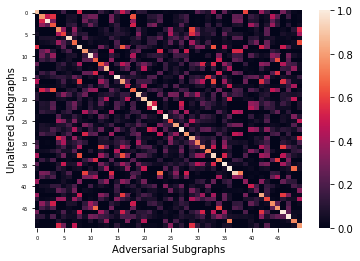

In [28]:
ax = sns.heatmap(adv_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/alexnet_cifar/adv_comb_heatmap.png', format='png', dpi=500)

In [29]:
moved_sim_mat = np.zeros((len(sample_graphs), len(moved_sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(moved_sample_graphs)):
        moved_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],moved_sample_graphs[j],lifetimes[i],moved_lifetimes[j])
        

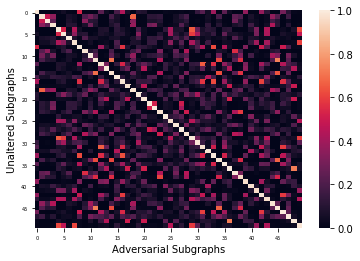

In [30]:
ax = sns.heatmap(moved_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/alexnet_cifar/moved_comb_heatmap.png', format='png', dpi=500)

In [39]:
moved_dists = np.array([get_adv_dists(ims[i], moved_ims[i]) for i in range(res_df.shape[0])])

TypeError: only integer scalar arrays can be converted to a scalar index

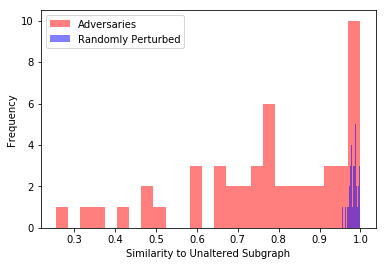

In [40]:
bins = 25
plt.hist(np.diagonal(adv_sim_mat), bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(np.diagonal(moved_sim_mat), bins, alpha=0.5, label='Randomly Perturbed', color='b')
plt.xlabel('Similarity to Unaltered Subgraph')
plt.ylabel('Frequency')
plt.legend()

Text(0, 0.5, 'Random Perturbation Similarity')

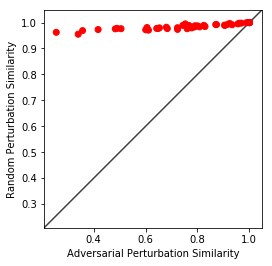

In [54]:
fig, ax = plt.subplots()
differs = np.diagonal(adv_sim_mat) - np.diagonal(moved_sim_mat)
colors = ['b' if differs[i] > 0 else 'r' for i in range(len(sample_graphs))]
ax.scatter(np.diagonal(adv_sim_mat), np.diagonal(moved_sim_mat), c=colors)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel('Adversarial Perturbation Similarity')
plt.ylabel('Random Perturbation Similarity')

In [41]:
# bins = 25
# plt.hist(dists, bins, alpha=0.5, label='Adversaries', color='r')
# plt.hist(moved_dists, bins, alpha=0.5, label='Random Pertubation', color='b')
# plt.xlabel('Distance to Unaltered Image')
# plt.ylabel('Frequency')
# plt.legend()

In [42]:
def compute_num_generators(g):
    return len(g)
def compute_num_edges(g):
    num_edges = 0
    for sgk in g:
        num_edges += len(g[sgk].edges())
    return num_edges

In [43]:
num_generators = [compute_num_generators(g) for g in sample_graphs]
adv_num_generators = [compute_num_generators(g) for g in adv_sample_graphs]
moved_num_generators = [compute_num_generators(g) for g in moved_sample_graphs]

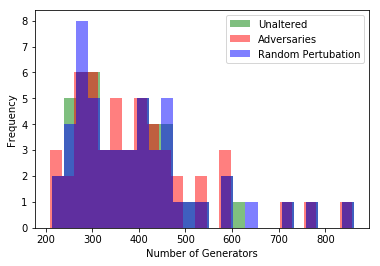

In [44]:
bins = 25
plt.hist(num_generators, bins, alpha=0.5, label='Unaltered', color='g')
plt.hist(adv_num_generators, bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(moved_num_generators, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Number of Generators')
plt.ylabel('Frequency')
plt.legend()

In [45]:
num_edges = np.array([compute_num_edges(g) for g in sample_graphs])
adv_num_edges = np.array([compute_num_edges(g) for g in adv_sample_graphs])
moved_num_edges = np.array([compute_num_edges(g) for g in moved_sample_graphs])

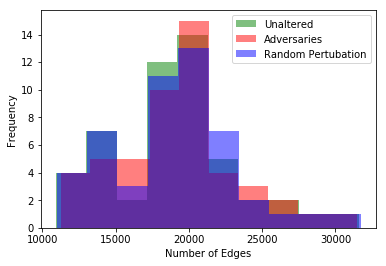

In [46]:
bins = 10
plt.hist(num_edges, bins, alpha=0.5, label='Unaltered', color='g')
plt.hist(adv_num_edges, bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(moved_num_edges, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Number of Edges')
plt.ylabel('Frequency')
plt.legend()

(9944.440143369175, 32748.559856630818)

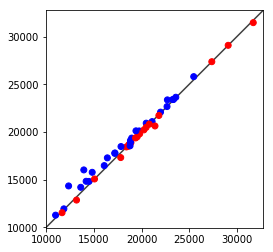

In [47]:
fig, ax = plt.subplots()
differs = adv_num_edges - num_edges
colors = ['b' if differs[i] > 0 else 'r' for i in range(moved_num_edges.shape[0])]
ax.scatter(moved_num_edges, adv_num_edges, c=colors)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [48]:
differs[differs >= 0].shape[0]/num_edges.shape[0]

0.78

- Compute the set differences for each adversary and compare these set differences to each of the unaltered images like we did for the adv_sim_mat above. 
- Sort this similarity matrix by the _predicted_ class of the adversary. We would expect to see some sort of relationship emerge if these subgraphs were targeting class-specific information within the persistent subgraphs
- Compute these differences based on the composed graphs like in `lifetime_weighted_edge_distance()`

In [49]:
def set_difference(subgraphs1, subgraphs2):
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    remove_edges = []
    edges2 = []
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        remove_edges += list(g.edges)
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        edges2 += list(g.edges)
    keep_edges = set(edges2).difference(set(remove_edges))
    ret_graph = nx.compose_all([subgraphs2[k] for k in sg2keys])
    rge = list(ret_graph.edges())
    ret_graph.remove_edges_from(e for e in rge if e not in keep_edges)
    return ret_graph

In [50]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_adv_df = adv_df.sort_values(by=['prediction'])

In [51]:
sorted_adv_df.head()

,class,loss,prediction
22,4,-6.739214,0
18,8,-6.739214,0
41,6,-6.739214,0
40,4,-6.739214,0
1,8,-6.739214,1


In [55]:
adv_differences = [set_difference(sample_graphs[i], adv_sample_graphs[i]) for i in range(len(sample_graphs))]

combs = []
for i in range(len(sample_graphs)):
    combs.append(nx.compose_all([sample_graphs[i][k] for k in sample_graphs[i]]))

In [56]:
diff_sim_mat = np.zeros((len(combs),len(adv_differences)))
for i in range(len(combs)):
    g = combs[i]
    for j in range(len(adv_differences)):
        ag = adv_differences[j]
        diff_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

/home/tgebhart/.local/lib/python3.6/site-packages/scipy/spatial/distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [57]:
sorted_diff_sim_mat = np.empty(diff_sim_mat.shape)
sidxs = list(sorted_adv_df.index)
# aidxs = list(sorted_adv_df.index)
aidxs = sidxs
for i in range(len(sidxs)):
    for j in range(len(aidxs)):
        sorted_diff_sim_mat[i,j] = diff_sim_mat[sidxs[i],aidxs[j]]
        
sdsmdf = pd.DataFrame(sorted_diff_sim_mat, columns=sorted_adv_df['prediction'], index=sorted_res_df['prediction'])

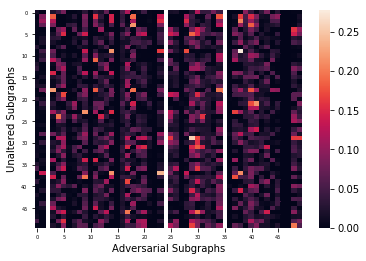

In [58]:
ax = sns.heatmap(diff_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/alexnet_cifar/adv_diff_heatmap.png', format='png', dpi=500)